Import libraries

In [1]:
import seaborn as sn
import pandas as pd
import json, os
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import time
import random

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


Specify a constant seeder for processes

In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)

In [3]:
def dropEmpty(tokens0):
    tokens = []
    for i in range(0, len(tokens0)):
        temp = tokens0[i]
        if temp != []:
            tokens.append(temp)
    return tokens

def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string 
    count = 0
    for ele in s: 
        if count==0:
            str1 = str1 + ele
        else:
            str1 = str1 + ' ' + ele
        count = count + 1
        #str1 += ele  
    
    # return string  
    return str1

def prepareData(data):
        
    # lowercase
    lines = []
    labels = []
    headlines = []
    for i in range(0, len(data)):
        labels.append(int(data[i][1]))
        headlines.append(data[i][0])
        line = data[i][2:]
        lows = [w.lower() for w in line]
        lines.append(lows)
    
    texts = []
    for i in range(0, len(lines)):
        texts.append(listToString(lines[i]))
    
    return texts, labels, headlines 

Read dataset

In [4]:
root_path = os.path.join('..', '..')
with open(os.path.join(root_path, 'data', 'dataset.csv'), newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = dropEmpty(data)

Shuffle dataset

In [5]:
random.shuffle(data)

In [6]:
texts, labels, headlines = prepareData(data)

Explore data

Elements in dataset: 4184
2 categories found:
0
1


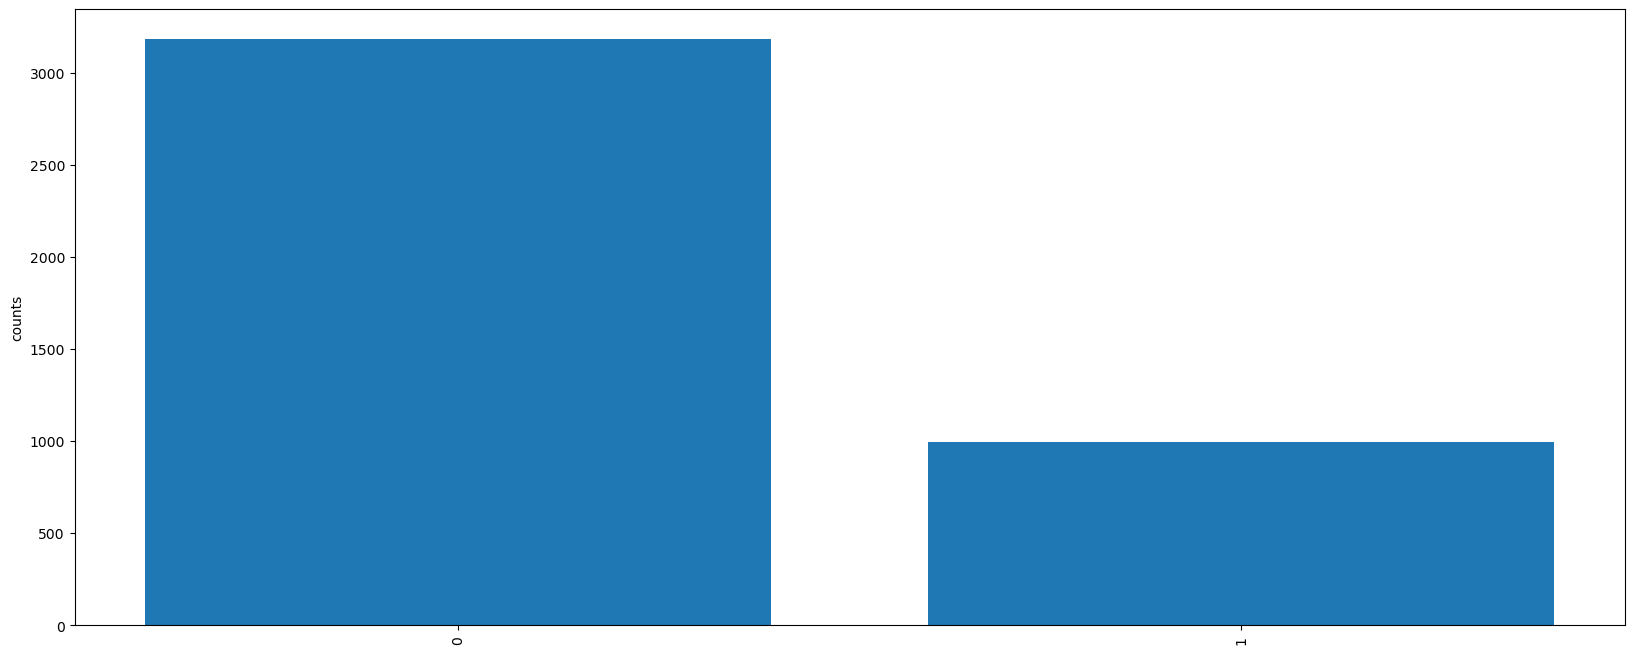

In [7]:
n_elements=len(headlines)
print('Elements in dataset:', n_elements)
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
print("{} categories found:".format(n_categories))
for category in categories:
    print(category)
    
fig=plt.figure(figsize=(20,8))
lbl, counts = np.unique(labels,return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks,lbl)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.show()

In [8]:
data = pd.DataFrame(({'Text': texts, 'Labels': labels}))

Split to train-val-test

In [9]:
val_ratio = 0.10

In [10]:
train_val_data, test_data = train_test_split(data, test_size=val_ratio, random_state=seed, stratify=data['Labels'])
train_data, val_data = train_test_split(train_val_data, test_size=val_ratio, random_state=seed, stratify=train_val_data['Labels'])
# print(len(data))
# print(len(train_val_data))
# print(len(test_data))
# print(len(train_data))
# print(len(val_data))
# print(len(val_data)+len(train_data)+len(test_data))
# print(len(val_data)+len(train_data))

Prepare data

In [11]:
X_train_list = train_data["Text"].tolist()
X_val_list = val_data["Text"].tolist()
X_test_list = test_data["Text"].tolist()

In [12]:
vectorizer = TfidfVectorizer()

In [13]:
x_train = vectorizer.fit_transform(X_train_list)
x_val = vectorizer.transform(X_val_list)
x_test = vectorizer.transform(X_test_list)

In [14]:
y_train = train_data["Labels"].tolist()
y_val = val_data["Labels"].tolist()
y_test = test_data["Labels"].tolist()

In [15]:
userModel = "RF"

Train model

In [16]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

if userModel == "SVM":
    model = SVC(kernel='rbf', gamma=100)
elif userModel == "RF":
    model = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
elif userModel == "DT":
    model = tree.DecisionTreeClassifier(max_depth=120)
elif userModel == "KNN":
    model = KNeighborsClassifier(n_neighbors=1)
elif userModel == "LR":
    model = LogisticRegression()
    
model.fit(x_train, y_train)

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)

Training...
Training is completed after 4955


In [17]:
print(classification_report(y_val, model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       287
           1       0.98      0.61      0.75        90

    accuracy                           0.90       377
   macro avg       0.94      0.80      0.85       377
weighted avg       0.91      0.90      0.90       377



Make predictions on the testing set and compute evaluation metrics

In [18]:
predictions = model.predict(x_test)
#predScores = model.predict_proba(x_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       319
           1       0.98      0.60      0.75       100

    accuracy                           0.90       419
   macro avg       0.94      0.80      0.84       419
weighted avg       0.91      0.90      0.89       419



TP= 60
TN= 318
FP= 1
FN= 40
Accuracy:90.21%
Precision:98.36%
Recall:60.00%
Roc_Auc score:79.84%
F1 score:74.53%
F2 score:65.08%


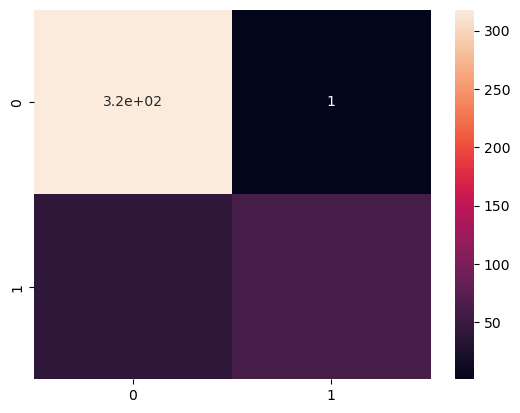

In [19]:
accuracy=accuracy_score(y_test, predictions)
precision=precision_score(y_test, predictions)
recall=recall_score(y_test, predictions)
roc_auc=roc_auc_score(y_test, predictions)
f1=f1_score(y_test, predictions)
f2 = (5*precision*recall) / (4*precision+recall)

conf_matrix = confusion_matrix(y_test, predictions)
sn.heatmap(conf_matrix, annot=True)

tn, fp, fn, tp = conf_matrix.ravel()
acc = ((tp+tn)/(tp+tn+fp+fn))
print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F1 score:%.2f%%"%(f1*100))
print("F2 score:%.2f%%"%(f2*100))